In [34]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist


In [36]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [37]:
# Preprocessing data
X_train = X_train.reshape((60000, 28, 28, 1))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((10000, 28, 28, 1))
X_test = X_test.astype('float32') / 255

In [38]:
from keras.src.layers import Reshape, UpSampling2D, Conv2DTranspose, Layer, Dense
from keras.src import layers

batch_size = 128
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

class Sampler(Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size)) 
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) 
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x) 
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x) 
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

#### VAE loss:
$$
\begin{aligned}
\mathcal{L}(\theta, \phi; x^{(i)}) &= -\mathbb{E}_{z \sim q_\phi(z|x^{(i)})}[\log p_\theta(x^{(i)}|z)] + D_{KL}(q_\phi(z|x^{(i)})||p(z)) \\
&= -\mathbb{E}_{z \sim q_\phi(z|x^{(i)})}[\log p_\theta(x^{(i)}|z)] + D_{KL}(q_\phi(z|x^{(i)})||\mathcal{N}(0, I))
\end{aligned}
$$

In [54]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss") 
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss") 
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]


    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"total_loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(), }

In [55]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.legacy.Adam())
vae.fit(X_train, epochs=30, batch_size=batch_size)

Epoch 1/30


2023-10-04 16:20:33.430047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 25s 33ms/step - total_loss: 348.0389 - reconstruction_loss: 334.9849 - kl_loss: 13.0572
Epoch 2/30
469/469 [==============================] - 10s 21ms/step - total_loss: 290.9990 - reconstruction_loss: 284.9450 - kl_loss: 6.0535
Epoch 3/30
469/469 [==============================] - 10s 21ms/step - total_loss: 286.7118 - reconstruction_loss: 278.7638 - kl_loss: 7.9472
Epoch 4/30
469/469 [==============================] - 10s 22ms/step - total_loss: 291.2564 - reconstruction_loss: 281.0005 - kl_loss: 10.2561
Epoch 5/30
469/469 [==============================] - 10s 22ms/step - total_loss: 294.4797 - reconstruction_loss: 282.9611 - kl_loss: 11.5164
Epoch 6/30
469/469 [==============================] - 11s 23ms/step - total_loss: 307.9587 - reconstruction_loss: 288.0807 - kl_loss: 19.8744
Epoch 7/30
469/469 [==============================] - 10s 22ms/step - total_loss: 360.4170 - reconstruction_loss: 300.8816 - kl_loss: 59.5206
Epoch 8/30
469/469 

1/1 [==============================] - 0s 14ms/step


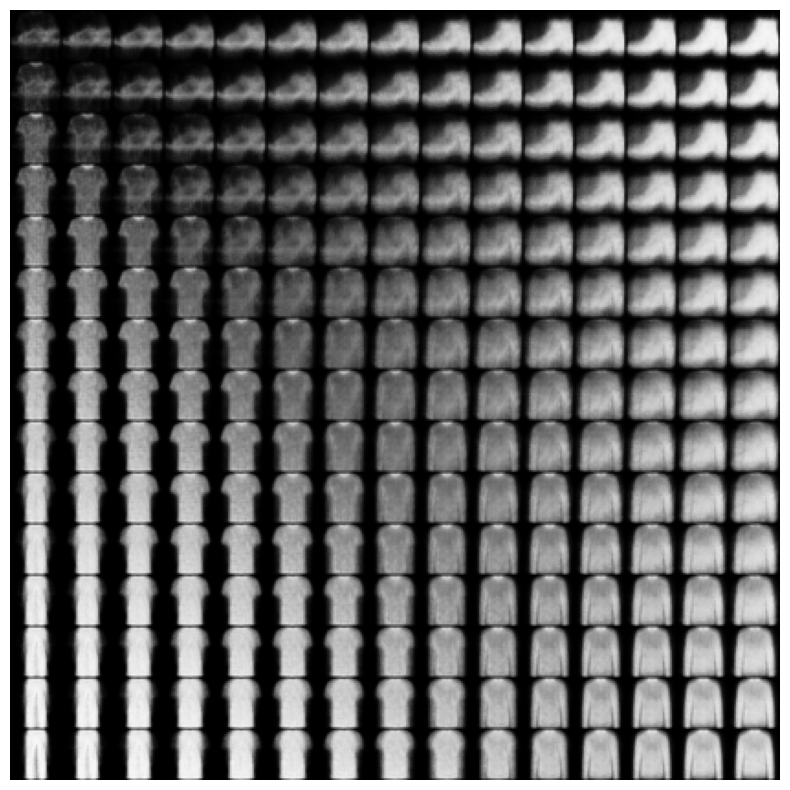

In [61]:
n = 15
img_size = 28
figure = np.zeros((img_size * n, img_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]]) 
        x_decoded = decoder.predict(z_sample)
        image = x_decoded[0].reshape(img_size, img_size)
        figure[i * img_size: (i + 1) * img_size, 
               j * img_size: (j + 1) * img_size] = image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(figure, cmap='Greys_r')
ax.axis('off')
plt.show()